In [1]:
#plot learning curve
import matplotlib.pyplot as plt
%matplotlib inline

def plot(accuracy,max_epochs):
    fig, ax = plt.subplots(1, 1)
    ax.set_title('Validation Loss')
    ax.set_xlim([0, max_epochs+10])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Validation Loss')
    ax.plot(accuracy, c='r', label='Validation Loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()

Using TensorFlow backend.


... loading data
... done loading data
Configuration space object:
  Hyperparameters:
    batch_size, Type: UniformInteger, Range: [16, 128], Default: 16, on log-scale
    filter_size, Type: Categorical, Choices: {3, 5}, Default: 3
    learning_rate, Type: UniformFloat, Range: [0.0001, 0.1], Default: 0.1, on log-scale
    num_filters, Type: UniformInteger, Range: [8, 64], Default: 16, on log-scale

RUN DONE... 0.02410000000000001
RUN DONE... 0.017800000000000038
RUN DONE... 0.01429999999999998
RUN DONE... 0.0131
RUN DONE... 0.011499999999999955
RUN DONE... 0.01100000000000001
RUN DONE... 0.009299999999999975
RUN DONE... 0.009399999999999964
RUN DONE... 0.009099999999999997
RUN DONE... 0.009399999999999964
RUN DONE... 0.008499999999999952
RUN DONE... 0.009299999999999975
RUN DONE... 0.007900000000000018
RUN DONE... 0.008000000000000007
RUN DONE... 0.007299999999999973
RUN DONE... 0.007199999999999984
RUN DONE... 0.008199999999999985
RUN DONE... 0.006800000000000028
RUN DONE... 0.0063999

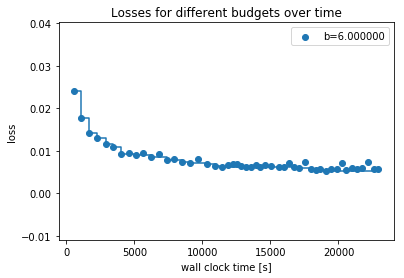

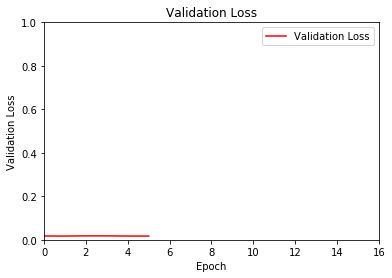

In [2]:
import logging
import gzip
import json
import os
import pickle
import numpy as np

logging.basicConfig(level=logging.WARNING)

try:
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from keras.layers import Conv2D, MaxPooling2D
    from keras import backend as K
except:
    raise ImportError("For this example you need to install keras.")

import hpbandster.core.nameserver as hpns

from hpbandster.optimizers import RandomSearch

import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH
from hpbandster.core.worker import Worker
import argparse

import hpbandster.visualization as hpvis

#from cnn_mnist_solution import mnist

def onehot(labels):
    """this creates a one hot encoding from a flat vector:
    i.e. given y = [0,2,1]
     it creates y_one_hot = [[1,0,0], [0,0,1], [0,1,0]]
    """
    classes = np.unique(labels)
    n_classes = classes.size
    one_hot_labels = np.zeros(labels.shape + (n_classes,))
    for c in classes:
        one_hot_labels[labels == c, c] = 1
    return one_hot_labels

def mnist(datasets_dir='./data'):
    if not os.path.exists(datasets_dir):
        os.mkdir(datasets_dir)
    data_file = os.path.join(datasets_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_file):
        print('... downloading MNIST from the web')
        try:
            import urllib
            urllib.urlretrieve('http://google.com')
        except AttributeError:
            import urllib.request as urllib
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        urllib.urlretrieve(url, data_file)

    print('... loading data')
    # Load the dataset
    f = gzip.open(data_file, 'rb')
    try:
        train_set, valid_set, test_set = pickle.load(f, encoding="latin1")
    except TypeError:
        train_set, valid_set, test_set = pickle.load(f)
    f.close()

    test_x, test_y = test_set
    test_x = test_x.astype('float32')
    test_x = test_x.astype('float32').reshape(test_x.shape[0], 28, 28, 1)
    test_y = test_y.astype('int32')
    valid_x, valid_y = valid_set
    valid_x = valid_x.astype('float32')
    valid_x = valid_x.astype('float32').reshape(valid_x.shape[0], 28, 28, 1)
    valid_y = valid_y.astype('int32')
    train_x, train_y = train_set
    train_x = train_x.astype('float32').reshape(train_x.shape[0], 28, 28, 1)
    train_y = train_y.astype('int32')
    print('... done loading data')
    return train_x,onehot(train_y), valid_x, onehot(valid_y), test_x,onehot(test_y)

def train_again(config,budget):
    
    x_train, y_train, x_valid, y_valid, x_test, y_test = mnist("./")
    model = Sequential()

    model.add(Conv2D(config['num_filters'], kernel_size=(config['filter_size'],config['filter_size']),
                         activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(config['num_filters'], kernel_size=(config['filter_size'], config['filter_size']),
                         activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
      
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))

    optimizer = keras.optimizers.SGD(lr=config['learning_rate'])

    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=optimizer,metrics=['accuracy'])

    history=model.fit(x_train, y_train,
                  batch_size=config["batch_size"],epochs=budget,verbose=0,validation_data=(x_test, y_test))
    
    test_score = model.evaluate(x_test, y_test, verbose=0)

    return history,test_score[1]
    
class MyWorker(Worker):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.x_train, self.y_train, self.x_valid, self.y_valid, self.x_test, self.y_test = mnist("./")

    def compute(self, config, budget,**kwargs):
        """
        Evaluates the configuration on the defined budget and returns the validation performance.
        Args:
            config: dictionary containing the sampled configurations by the optimizer
            budget: (float) amount of time/epochs/etc. the model can use to train
        Returns:
            dictionary with mandatory fields:
                'loss' (scalar)
                'info' (dict)
        """
        lr = config["learning_rate"]
        num_filters = config["num_filters"]
        batch_size = config["batch_size"]
        epochs = budget

        # TODO: train and validate your convolutional neural networks here
        # GRAPH : I/P --> CL1 --> RELU --> POOL1 --> CL2 --> RELU --> POOL2 --> DROP --> FC --> RELU --> DROP --> SOFTMAX
        model = Sequential()
        model.add(Conv2D(config['num_filters'], kernel_size=(config['filter_size'],\
                                                             config['filter_size']), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(config['num_filters'], kernel_size=(config['filter_size'], \
                                                             config['filter_size']), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(10, activation='softmax'))
        
        optimizer = keras.optimizers.SGD(lr=config['learning_rate'])
        model.compile(loss=keras.losses.categorical_crossentropy,optimizer=optimizer, metrics=['accuracy'])
        history = model.fit(self.x_train, self.y_train, batch_size=config["batch_size"], \
                          epochs=epochs, verbose=0, validation_data=(self.x_test, self.y_test))
        train_score = model.evaluate(self.x_train, self.y_train, verbose=0)
        val_score = model.evaluate(self.x_valid, self.y_valid, verbose=0)
        test_score = model.evaluate(self.x_test, self.y_test, verbose=0)
        validation_error= 1-val_score[1]
        
        print("RUN DONE...", validation_error)
        
        # TODO: We minimize so make sure you return the validation error here
        return ({
            'loss': validation_error,  # this is the a mandatory field to run hyperband
            'info': {'test accuracy': test_score[1], 'train accuracy': train_score[1],\
                     'validation accuracy': val_score[1], 'number of parameters': model.count_params(),
                    }  # can be used for any user-defined information - also mandatory
        })

    @staticmethod
    def get_configspace():
        
        # TODO: Implement configuration space here. 
        #See https://github.com/automl/HpBandSter/blob/master/hpbandster/examples/example_5_keras_worker.py  for an example
        configspace = CS.ConfigurationSpace()
        lr = CSH.UniformFloatHyperparameter('learning_rate', lower=0.0001, upper=0.1, default_value='0.1', log=True)
        configspace.add_hyperparameters([lr])
        batch_size = CSH.UniformIntegerHyperparameter('batch_size', lower=16, upper=128, default_value=16, log=True)
        configspace.add_hyperparameters([batch_size])
        num_filters = CSH.UniformIntegerHyperparameter('num_filters', lower=8, upper=64, default_value=16, log=True)
        configspace.add_hyperparameters([num_filters])
        filter_size = CSH.CategoricalHyperparameter('filter_size', [3,5])
        configspace.add_hyperparameters([filter_size])
        print(configspace)
        return configspace

parser = argparse.ArgumentParser(description='Example 1 - sequential and local execution.')
parser.add_argument('--budget', type=float,
                    help='Maximum budget used during the optimization, i.e the number of epochs.', default=12)
parser.add_argument('--n_iterations', type=int, help='Number of iterations performed by the optimizer', default=20)
#args = parser.parse_args()

# Step 1: Start a nameserver
# Every run needs a nameserver. It could be a 'static' server with a
# permanent address, but here it will be started for the local machine with the default port.
# The nameserver manages the concurrent running workers across all possible threads or clusternodes.
# Note the run_id argument. This uniquely identifies a run of any HpBandSter optimizer.
NS = hpns.NameServer(run_id='example1', host='127.0.0.1', port=None)
NS.start()

# Step 2: Start a worker
# Now we can instantiate a worker, providing the mandatory information
# Besides the sleep_interval, we need to define the nameserver information and
# the same run_id as above. After that, we can start the worker in the background,
# where it will wait for incoming configurations to evaluate.
worker = MyWorker(nameserver='127.0.0.1', run_id='example1')
worker.run(background=True)

# Step 3: Run an optimizer
# Now we can create an optimizer object and start the run.
# Here, we run RandomSearch, but that is not essential.
# The run method will return the `Result` that contains all runs performed.
randomsearch = RandomSearch(configspace=worker.get_configspace(),
                  run_id='example1', nameserver='127.0.0.1',
                 # min_budget=int(args.budget), max_budget=int(args.budget))
                  min_budget=int(6), max_budget=int(6))
rsresult = randomsearch.run(n_iterations=50)

# Step 4: Shutdown
# After the optimizer run, we must shutdown the master and the nameserver.
randomsearch.shutdown(shutdown_workers=True)
NS.shutdown()

# Step 5: Analysis
# Each optimizer returns a hpbandster.core.result.Result object.
# It holds information about the optimization run like the incumbent (=best) configuration.
# For further details about the Result object, see its documentation.
# Here we simply print out the best config and some statistics about the performed runs.
id2config = rsresult.get_id2config_mapping()
incumbent = rsresult.get_incumbent_id()

print('Best found configuration:', id2config[incumbent]['config'])

# Plots the performance of the best found validation error over time
all_runs = rsresult.get_all_runs()
# Let's plot the observed losses grouped by budget,
hpvis.losses_over_time(all_runs)
plt.savefig("rsBC.png")

# TODO: retrain the best configuration (called incumbent) and compute the test error
#worker = MyWorker(nameserver='127.0.0.1', run_id='example1')
#res = worker.compute(config=id2config[incumbent]['config'], budget=6, working_directory='.',test=True)

taresults, testrun = train_again(config=id2config[incumbent]['config'], budget=6)
print("Training with best config:")
val_loss = taresults.history['val_loss']
print("VL...",val_loss)
plot(val_loss,len(val_loss))
print("Test Accuracy:")
print(testrun)
print("Test Error:")
print(1-testrun)